In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg', 'pdf')
sns.set_style("darkgrid")

from tqdm.notebook import tqdm
from ensembles import RandomForestMSE, GradientBoostingMSE

## Предобработка данных

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Выделим данные для обучения и целевую переменную. Удалим ненужный стобец id, это просто некоторый идентификатор продажи.

In [3]:
target = df["price"]

columns = df.columns.drop(["price", "id"])
data = df[columns]

Преобразуем столбец `date` и добавим в признаки год, месяц, день недели, день в году, день в месяце.

In [4]:
date = pd.to_datetime(df.date)
data = data.drop(columns=['date'])

date_features = pd.DataFrame({ "year": date.dt.year, "month": date.dt.month, "weekday": date.dt.weekday, "day_of_year": date.dt.day_of_year, "day_of_month": date.dt.day })
data = pd.concat([data, date_features], axis=1)

Выделим вещественные и категориальные признаки.

In [5]:
categorical = ["zipcode", "month", "weekday"]
numerical = data.columns.drop(categorical)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from category_encoders.target_encoder import TargetEncoder


X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.3, random_state=322)
enc = TargetEncoder(cols=categorical)
X_train = enc.fit_transform(X_train, y_train)
X_val = enc.transform(X_val)

X_train, X_val, y_train, y_val = np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

In [108]:
df = pd.read_csv("kc_house_data.csv")
columns = df.columns.drop(["id"])
data = df[columns]

date = pd.to_datetime(df.date)
data = data.drop(columns=['date'])

date_features = pd.DataFrame({ "year": date.dt.year, "month": date.dt.month, "weekday": date.dt.weekday, "day_of_year": date.dt.day_of_year, "day_of_month": date.dt.day })
data = pd.concat([data, date_features], axis=1)

categorical = ["zipcode", "month", "weekday"]
numerical = data.columns.drop(categorical)

numerical_data = data[numerical]

train_part = numerical_data[:10_000]
val_part = numerical_data[10_000:20_000]

columns = numerical_data.columns.drop(["price"])
test_part = val_part[columns]

train_part.to_csv("train_example.csv", index=False)
val_part.to_csv("val_example.csv", index=False)
test_part.to_csv("test_example.csv", index=False)

In [112]:
pd.DataFrame([1, 2, 3])

,0
0,1
1,2
2,3


In [8]:
rf_regr = RandomForestMSE(n_estimators=500)
rf_regr.fit(X_train, y_train)

* Рассматриваемые количества деревьев в ансамбле: 1-500
* Рассматриваемые глубины деревьев: 1-35 + без ограничения
* Рассматриваемые размерности подвыборок: 0.2, 0.4, 0.6, 0.8, 1.0


In [10]:
n_estimators = np.linspace(1, 500, 500, dtype=int)
losses = []
for n_est in tqdm(n_estimators):
    y_pred = rf_regr.predict(X_val, n_estimators=n_est)
    losses.append(mse(y_val, y_pred, squared=False))
losses = np.array(losses)
df_plot = pd.DataFrame({'loss': losses, 'n_estimators': n_estimators, 'time': rf_regr.history['time']})

  0%|          | 0/500 [00:00<?, ?it/s]

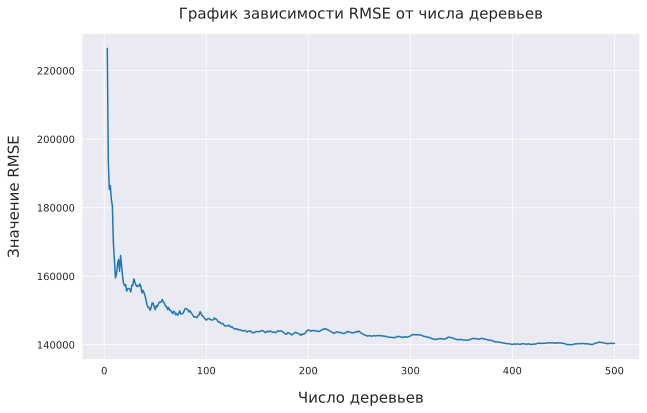

In [44]:
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от числа деревьев", pad=15, fontsize=15)
plt.xlabel("Число деревьев", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_plot[2:], x='n_estimators', y='loss', linewidth=1.5)
plt.savefig("rf_count.svg")

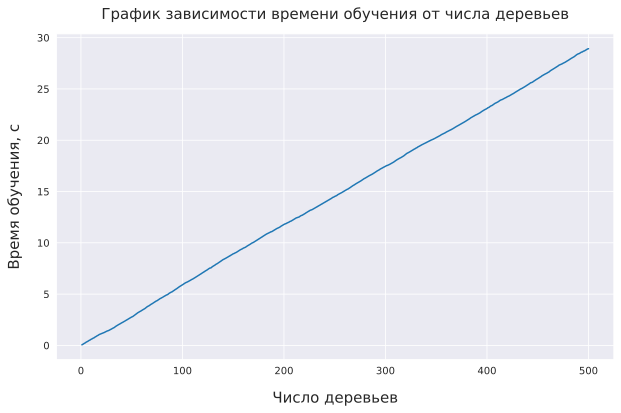

In [27]:
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от числа деревьев", pad=15, fontsize=15)
plt.xlabel("Число деревьев", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_plot, x='n_estimators', y='time', linewidth=1.5)
plt.savefig("rf_count_time.svg")

Зафиксируем число деревьев равным 300 и исследуем зависимость от максимальной глубины деревьев.

In [36]:
max_depth = np.arange(1, 36)
losses = []
times = []

for d in tqdm(max_depth):
    rf_regr = RandomForestMSE(n_estimators=400, max_depth=d)
    rf_regr.fit(X_train, y_train)
    y_pred = rf_regr.predict(X_val)
    losses.append(mse(y_val, y_pred, squared=False))
    times.append(rf_regr.history['time'][-1])

  0%|          | 0/34 [00:00<?, ?it/s]

In [37]:
losses = np.array(losses)
df_depth = pd.DataFrame({'loss': losses, 'max_depth': max_depth, 'time': times})

In [64]:
rf_regr = RandomForestMSE(n_estimators=400, max_depth=None)
rf_regr.fit(X_train, y_train)
y_pred = rf_regr.predict(X_val)
loss = mse(y_val, y_pred, squared=False)
nolimit_time = rf_regr.history['time'][-1]

/tmp/ipykernel_14810/4106702654.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


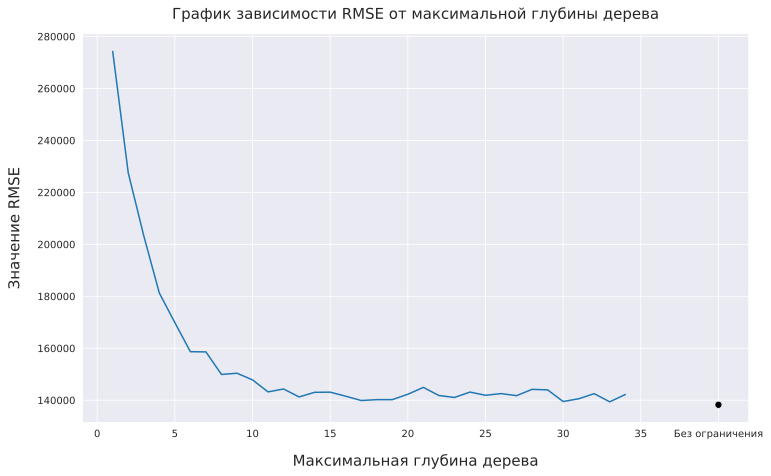

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от макcимальной глубины дерева", pad=15, fontsize=15)
plt.xlabel("Максимальная глубина дерева", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_depth, x='max_depth', y='loss', linewidth=1.5)
sns.scatterplot(x=[40], y=[loss], marker='o', s=50, color='black')
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = 'Без ограничения'
ax.set_xticklabels(labels)

plt.savefig("rf_depth.svg")

/tmp/ipykernel_14810/2886800536.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


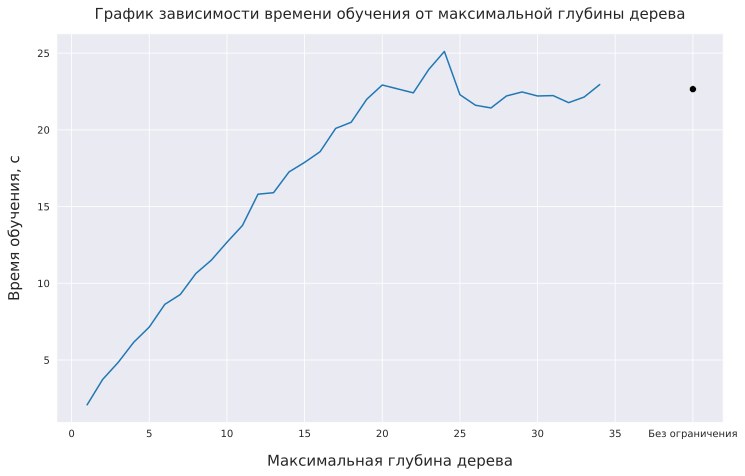

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от максимальной глубины дерева", pad=15, fontsize=15)
plt.xlabel("Максимальная глубина дерева", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_depth, x='max_depth', y='time', linewidth=1.5)
sns.scatterplot(x=[40], y=[nolimit_time], marker='o', s=50, color='black')
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = 'Без ограничения'
ax.set_xticklabels(labels)
plt.savefig("rf_depth_time.svg")

Зафиксируем максимальную глубину деревьев равной 

In [68]:
feature_subsample = np.linspace(0.1, 1.0, 10)
feature_subsample

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [69]:
feature_subsample = np.linspace(0.1, 1.0, 10)
losses = []
times = []

for f in tqdm(feature_subsample):
    rf_regr = RandomForestMSE(n_estimators=400, max_depth=None, feature_subsample_size=f)
    rf_regr.fit(X_train, y_train)
    y_pred = rf_regr.predict(X_val)
    losses.append(mse(y_val, y_pred, squared=False))
    times.append(rf_regr.history['time'][-1])

  0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
df_feature = pd.DataFrame({'loss': losses, 'feature_subsample': feature_subsample, 'time': times})

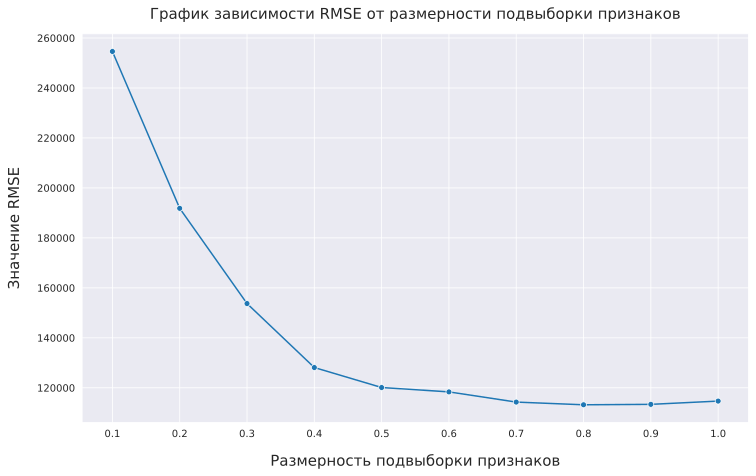

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от размерности подвыборки признаков", pad=15, fontsize=15)
plt.xlabel("Размерность подвыборки признаков", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_feature, x='feature_subsample', y='loss', linewidth=1.5, marker='o')

ax.set_xticks(feature_subsample)
plt.savefig("rf_feature.svg")

In [79]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

array([0.00254222, 0.00712017, 0.2472545 , 0.01139753, 0.00178196,
       0.02787491, 0.02156367, 0.00237032, 0.31769716, 0.01671136,
       0.00400371, 0.0161889 , 0.00150652, 0.19912118, 0.02755437,
       0.04346124, 0.02073032, 0.00924165, 0.00062089, 0.00450522,
       0.00328479, 0.00745745, 0.00600996])

In [85]:
list(zip(data.columns, rf.feature_importances_))

[('bedrooms', 0.002542224235742681),
 ('bathrooms', 0.007120165721849082),
 ('sqft_living', 0.24725450365306945),
 ('sqft_lot', 0.01139753057530699),
 ('floors', 0.001781960911327596),
 ('waterfront', 0.027874906422246406),
 ('view', 0.02156367040744129),
 ('condition', 0.002370321810346095),
 ('grade', 0.31769716216452387),
 ('sqft_above', 0.016711362462382494),
 ('sqft_basement', 0.004003714853671592),
 ('yr_built', 0.016188895949817986),
 ('yr_renovated', 0.0015065226447623144),
 ('zipcode', 0.1991211790944871),
 ('lat', 0.027554366038545393),
 ('long', 0.04346123781998032),
 ('sqft_living15', 0.020730324812362023),
 ('sqft_lot15', 0.009241645659375774),
 ('year', 0.0006208860537169504),
 ('month', 0.004505215743281431),
 ('weekday', 0.0032847920846839555),
 ('day_of_year', 0.007457451339580146),
 ('day_of_month', 0.006009959541499178)]

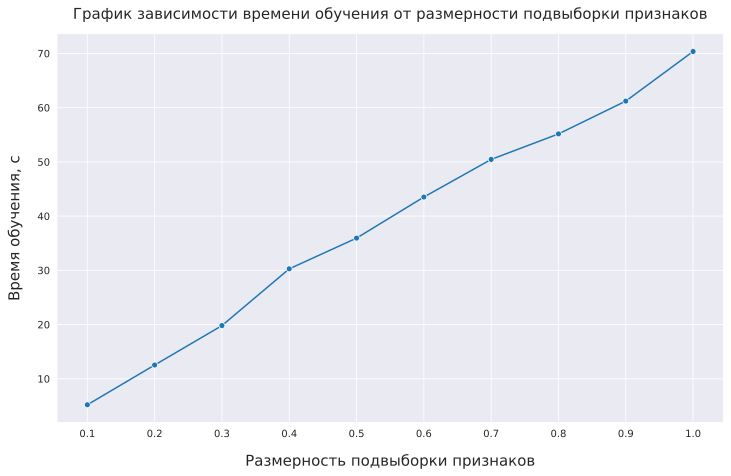

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от размерности подвыборки признаков", pad=15, fontsize=15)
plt.xlabel("Размерность подвыборки признаков", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_feature, x='feature_subsample', y='time', linewidth=1.5, marker='o')

ax.set_xticks(feature_subsample)
plt.savefig("rf_feature_time.svg")

## Градиентный бустинг

In [16]:
gb_regr = GradientBoostingMSE(n_estimators=500)

gb_regr.fit(X_train, y_train)

In [17]:
n_estimators = np.linspace(1, 500, 500, dtype=int)
losses = []
for n_est in tqdm(n_estimators):
    y_pred = gb_regr.predict(X_val, n_estimators=n_est)
    losses.append(mse(y_val, y_pred, squared=False))
losses = np.array(losses)
df_count = pd.DataFrame({'loss': losses, 'n_estimators': n_estimators, 'time': gb_regr.history['time']})

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
df_count

,loss,n_estimators,time
0,590672.849734,1,0.015363
1,540200.446983,2,0.039649
2,493056.706939,3,0.064336
3,454761.049950,4,0.071813
4,419127.144399,5,0.091408
...,...,...,...
495,105440.725376,496,9.581268
496,105428.088351,497,9.601100
497,105422.433525,498,9.617644
498,105423.932549,499,9.637119


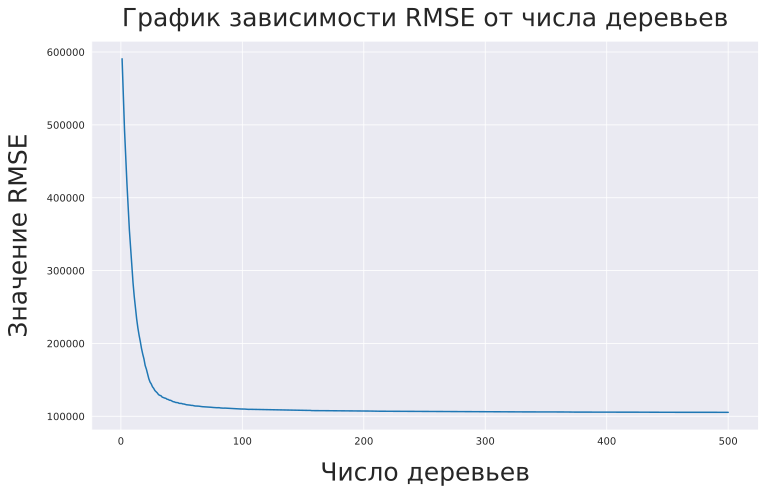

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от числа деревьев", pad=15, fontsize=25)
plt.xlabel("Число деревьев", labelpad=15, fontsize=25)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=25)
sns.lineplot(data=df_count[:], x='n_estimators', y='loss', linewidth=1.5)
plt.savefig("gb_count.svg")

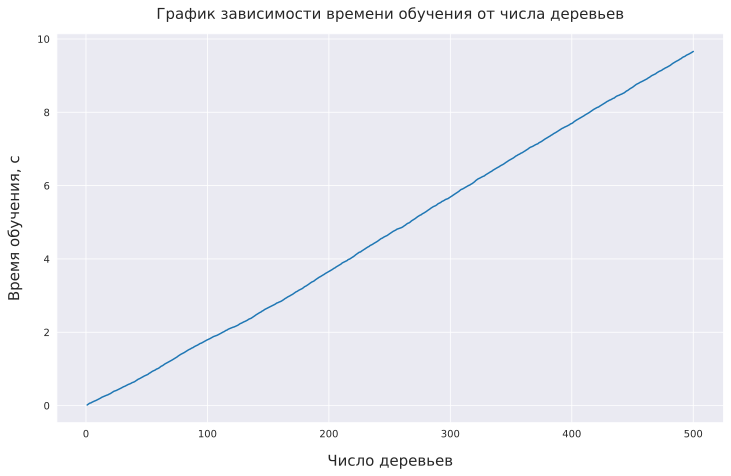

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от числа деревьев", pad=15, fontsize=15)
plt.xlabel("Число деревьев", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_count, x='n_estimators', y='time', linewidth=1.5)
plt.savefig("gb_count_time.svg")

In [41]:
max_depth = np.arange(1, 35)
losses = []
times = []

for d in tqdm(max_depth):
    gb_regr = GradientBoostingMSE(n_estimators=200, max_depth=d)
    gb_regr.fit(X_train, y_train)
    y_pred = gb_regr.predict(X_val)
    losses.append(mse(y_val, y_pred, squared=False))
    times.append(gb_regr.history['time'][-1])

  0%|          | 0/34 [00:00<?, ?it/s]

In [42]:
losses = np.array(losses)
df_depth = pd.DataFrame({'loss': losses, 'max_depth': max_depth, 'time': times})

In [54]:
gb_regr = GradientBoostingMSE(n_estimators=200, max_depth=None)
gb_regr.fit(X_train, y_train)
y_pred = gb_regr.predict(X_val)
loss = mse(y_val, y_pred, squared=False)
nolimit_time = gb_regr.history['time'][-1]

/tmp/ipykernel_21519/2899614930.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


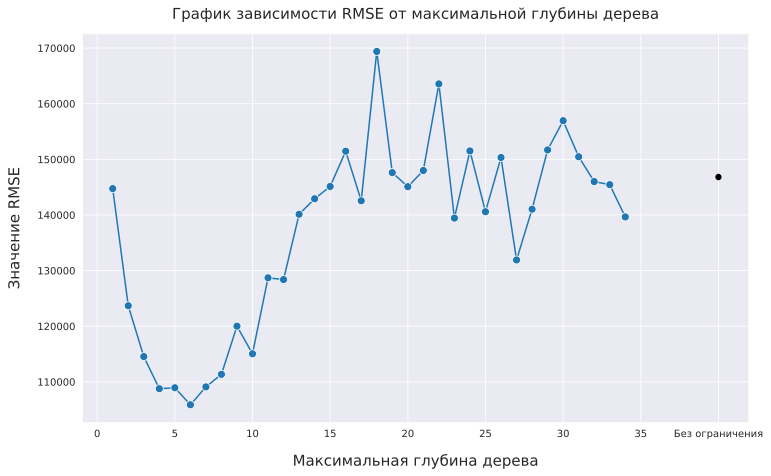

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от макcимальной глубины дерева", pad=15, fontsize=15)
plt.xlabel("Максимальная глубина дерева", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_depth, x='max_depth', y='loss', linewidth=1.5, marker='o', markersize=8)
sns.scatterplot(x=[40], y=[loss], marker='o', s=50, color='black')
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = 'Без ограничения'
ax.set_xticklabels(labels)

plt.savefig("gb_depth.svg")

/tmp/ipykernel_21519/2109408693.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


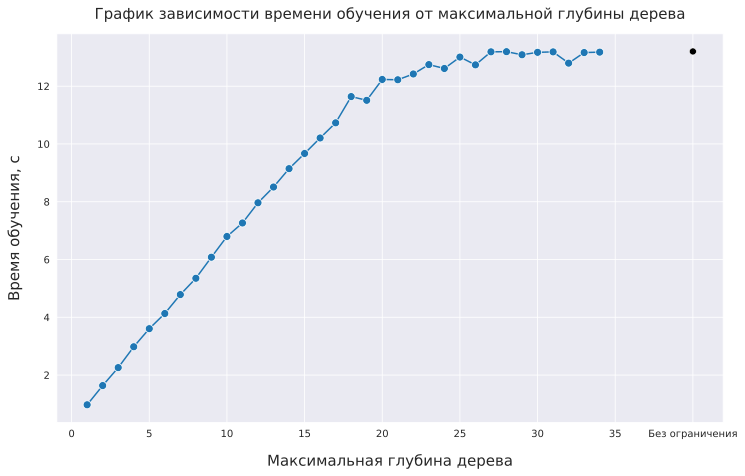

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от максимальной глубины дерева", pad=15, fontsize=15)
plt.xlabel("Максимальная глубина дерева", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_depth, x='max_depth', y='time', linewidth=1.5, marker='o', markersize=8)
sns.scatterplot(x=[40], y=[nolimit_time], marker='o', s=50, color='black')
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = 'Без ограничения'
ax.set_xticklabels(labels)
plt.savefig("gb_depth_time.svg")

In [66]:
feature_subsample = np.linspace(0.1, 1.0, 10)
losses = []
times = []

for f in tqdm(feature_subsample):
    gb_regr = GradientBoostingMSE(n_estimators=200, max_depth=6, feature_subsample_size=f)
    gb_regr.fit(X_train, y_train)
    y_pred = gb_regr.predict(X_val)
    losses.append(mse(y_val, y_pred, squared=False))
    times.append(gb_regr.history['time'][-1])

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
df_feature = pd.DataFrame({'loss': losses, 'feature_subsample': feature_subsample, 'time': times})

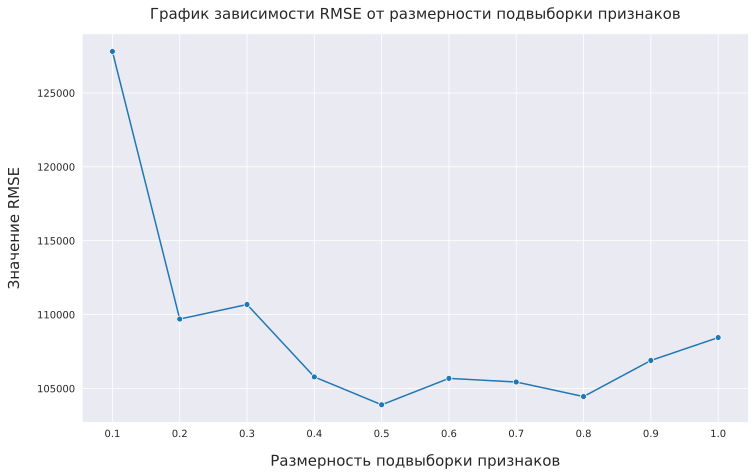

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от размерности подвыборки признаков", pad=15, fontsize=15)
plt.xlabel("Размерность подвыборки признаков", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_feature, x='feature_subsample', y='loss', linewidth=1.5, marker='o')

ax.set_xticks(feature_subsample)
plt.savefig("gb_feature.svg")

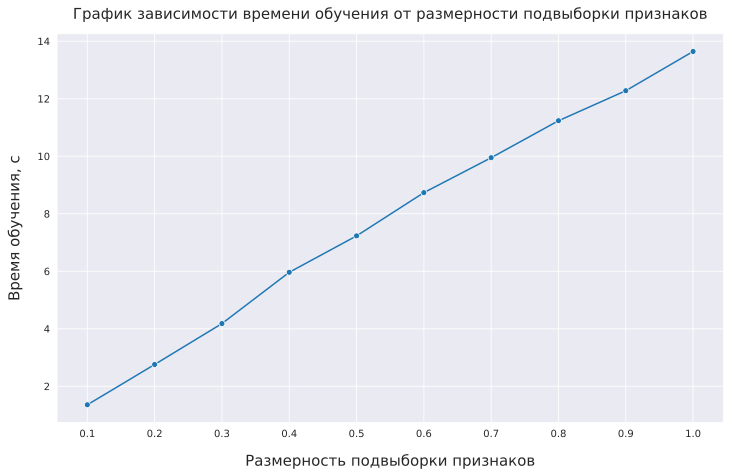

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от размерности подвыборки признаков", pad=15, fontsize=15)
plt.xlabel("Размерность подвыборки признаков", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_feature, x='feature_subsample', y='time', linewidth=1.5, marker='o')

ax.set_xticks(feature_subsample)
plt.savefig("gb_feature_time.svg")

In [81]:
learning_rate = np.logspace(-4, 0, 9)
learning_rate

array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00])

In [88]:
learning_rate = np.logspace(-4, 0, 9)
losses = []
times = []

for lr in tqdm(learning_rate):
    gb_regr = GradientBoostingMSE(n_estimators=200, max_depth=6, feature_subsample_size=0.5, learning_rate=lr)
    gb_regr.fit(X_train, y_train)
    y_pred = gb_regr.predict(X_val)
    losses.append(mse(y_val, y_pred, squared=False))
    times.append(gb_regr.history['time'][-1])

  0%|          | 0/9 [00:00<?, ?it/s]

In [89]:
df_lr = pd.DataFrame({'loss': losses, 'learning_rate': learning_rate, 'time': times})

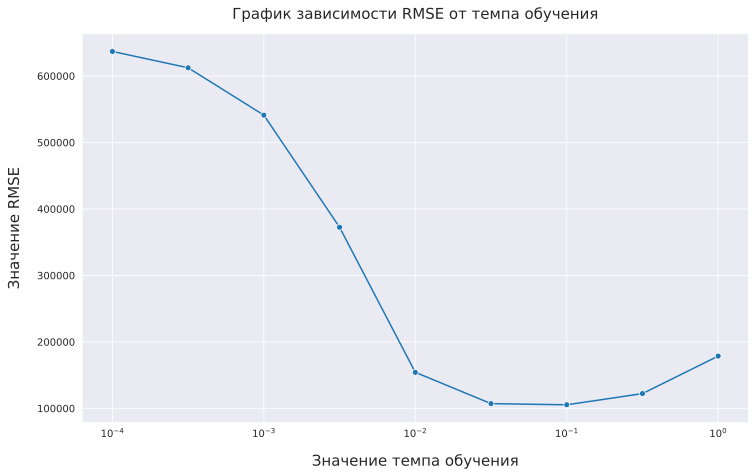

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости RMSE от темпа обучения", pad=15, fontsize=15)
plt.xlabel("Значение темпа обучения", labelpad=15, fontsize=15)
plt.ylabel("Значение RMSE", labelpad=15, fontsize=15)
sns.lineplot(data=df_lr, x='learning_rate', y='loss', linewidth=1.5, marker='o')

ax.set_xscale('log')
plt.savefig("gb_lr.svg")

In [91]:
df_lr

,loss,learning_rate,time
0,636907.136928,0.000100,6.880407
1,612319.701126,0.000316,6.777971
2,541099.740617,0.001000,7.405327
3,372476.135249,0.003162,7.506512
4,154204.197630,0.010000,7.472244
5,107117.576933,0.031623,7.395664
6,105378.783737,0.100000,7.506127
7,122217.915080,0.316228,7.511771
8,178665.861399,1.000000,7.596772


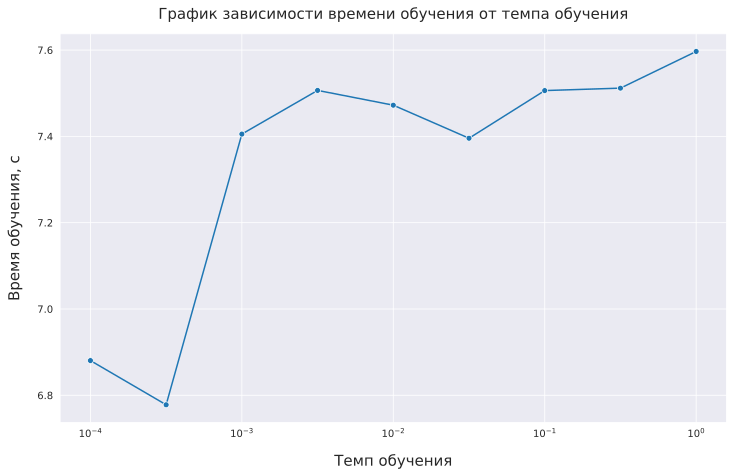

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
plt.title("График зависимости времени обучения от темпа обучения", pad=15, fontsize=15)
plt.xlabel("Темп обучения", labelpad=15, fontsize=15)
plt.ylabel("Время обучения, с", labelpad=15, fontsize=15)
sns.lineplot(data=df_lr, x='learning_rate', y='time', linewidth=1.5, marker='o')

ax.set_xscale('log')
plt.savefig("gb_lr_time.svg")